# Demand Forecaster

## 1) Business problem

URL Project: [Sales Prediction for Big Mart Outlets](https://www.kaggle.com/datasets/shivan118/big-mart-sales-prediction-datasets?select=test.csv)

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

**Data Dictionary**

We have a train (8523) and test (5681) data set, the train data set has both input and output variable(s). You need to predict the sales for the test data set.

#### Train file:
CSV containing the item outlet information with a sales value

**Variable Description**
* *Item_Identifier*: Unique product ID
* *Item_Weight*: Weight of product
* *Item_Fat_Content*: Whether the product is low fat or not
* *Item_Visibility*: The % of the total display area of all products in a store allocated to the particular product
* *Item_Type*: The category to which the product belongs
* *Item_MRP*: Maximum Retail Price (list price) of the product
* *Outlet_Identifier*: Unique store ID
* *Outlet_Establishment_Year*: The year in which the store was established
* *Outlet_Size*: The size of the store in terms of ground area covered
* *Outlet_Location_Type*: The type of city in which the store is located
* *Outlet_Type*: Whether the outlet is just a grocery store or some sort of supermarket
* *Item_Outlet_Sales*: sales of the product in t particular store. This is the outcome variable to be predicted.

### Test file:
CSV containing item outlet combinations for which sales need to be forecasted

**Variable Description**
* *Item_Identifier*:  Unique product ID
* *Item_Weight*: Weight of product
* *Item_Fat_Content*:  Whether the product is low fat or not
* *Item_Visibility*: The % of the total display area of all products in a store allocated to the particular product
* *Item_Type*: The category to which the product belongs
* *Item_MRP*:  Maximum Retail Price (list price) of the product
* *Outlet_Identifier*:  Unique store ID
* *Outlet_Establishment_Year*:  The year in which store store was established
* *Outlet_Size*:  The size of the store in terms of ground area covered
* *Outlet_Location_Type*: The type of city in which the store is located
* *Outlet_Type*: whether the outlet is just a grocery store or some sort of supermarket

### Submission file format
**Variable Description**
* *Item_Identifier*:  Unique product ID
* *Outlet_Identifier*:  Unique store ID
* *Item_Outlet_Sales*:  Sales of the product in t particular store. This is the outcome variable to be predicted.

**Evaluation Metric**

Your model performance will be evaluated on the basis of your prediction of the sales for the test data (test.csv), which contains similar data-points as train except for the sales to be predicted. Your submission needs to be in the format as shown in the same sample submission.

We at our end, have the actual sales for the test dataset, against which your predictions will be evaluated. We will use the Root Mean Square Error value to judge your response.

### 1.1) Imports and Load Data

In [2]:
import pandas as pd
import numpy as np

from scipy.stats import normaltest, zscore
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import missingno

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
sns.set_context("paper")

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### 1.2) Utilities Functions

In [4]:
def currencyFormatting(value):
    if value / 1000000 > 1:
        return f'$ {str(round(value/1000000, 2))}M'
    elif value / 100000 > 1:
        return f'$ {str(round(value/100000, 2))}KK'
    elif value / 1000 > 1:
        return f'$ {str(round(value/10000, 2))}k'
    else: 
        return f'$ {str(round(value, 2))}'

In [5]:
def resumeNumber(value):
    if value / 1000000 > 1:
        return f'{str(round(value/1000000, 2))}M'
    elif value / 100000 > 1:
        return f'{str(round(value/100000, 2))}KK'
    elif value / 1000 > 1:
        return f'{str(round(value/10000, 2))}k'
    else: 
        return f'{str(round(value, 2))}'

## 2) EDA - Exploratory Data Analysis

In [6]:
df_train_raw = pd.read_csv('../data/train.csv')
df_valid_raw = pd.read_csv('../data/test.csv')

In [7]:
display(df_train_raw.shape)
display(df_train_raw.head())

(8523, 12)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [8]:
display(df_valid_raw.shape)
display(df_valid_raw.head())

(5681, 11)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [9]:
df_train_raw.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [10]:
df_valid_raw.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [11]:
df_train_raw.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [12]:
df_train_raw.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# 3) Divisão dos dados em Treino e Teste

In [13]:
features_columns = [
    'Item_Identifier', 
    'Item_Weight', 
    'Item_Fat_Content', 
    'Item_Visibility',
    'Item_Type', 
    'Item_MRP', 
    'Outlet_Identifier',
    'Outlet_Establishment_Year', 
    'Outlet_Size', 
    'Outlet_Location_Type',
    'Outlet_Type'
]

target_column = ['Item_Outlet_Sales']

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df_train_raw[features_columns], df_train_raw[target_column])

In [15]:
display(x_train.head(3))
display(x_test.head(3))

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4644,FDK02,12.500,Low Fat,0.112682,Canned,119.1440,OUT018,2009,Medium,Tier 3,Supermarket Type2
3567,FDR56,15.500,Regular,0.101336,Fruits and Vegetables,196.5768,OUT017,2007,NaN,Tier 2,Supermarket Type1
2016,FDT40,5.985,Low Fat,0.096337,Frozen Foods,125.2678,OUT017,2007,NaN,Tier 2,Supermarket Type1


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
1748,FDS58,9.285,Regular,0.021049,Snack Foods,161.0578,OUT045,2002,NaN,Tier 2,Supermarket Type1
3681,FDI60,7.220,Regular,0.038399,Baking Goods,61.9510,OUT045,2002,NaN,Tier 2,Supermarket Type1
2557,FDG02,NaN,Low Fat,0.011207,Canned,191.4188,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [16]:
display(y_train.head(3))
display(y_test.head(3))

,Item_Outlet_Sales
4644,3235.7880
3567,3350.3056
2016,763.0068


,Item_Outlet_Sales
1748,2406.8670
3681,1518.0240
2557,3998.7948


# 4) Lidando com dados outliers

**Item_Identifier**

In [17]:
x_train['Item_Identifier'].value_counts()

Item_Identifier
FDX20    9
FDG33    9
FDW13    8
FDF56    8
NCY18    8
        ..
FDO33    1
DRL59    1
FDT35    1
FDK57    1
FDZ57    1
Name: count, Length: 1554, dtype: int64

Essa variável não tem muito o que fazer, embora itens que aparecem apenas uma vez podem ser uma pedra no sapato.

**Item_Weight**

<Axes: xlabel='Item_Weight'>

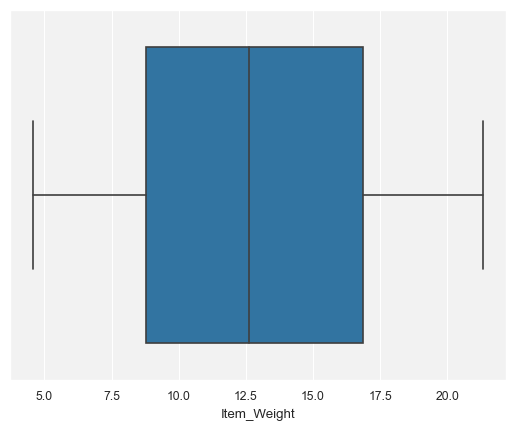

In [18]:
sns.boxplot(x=x_train['Item_Weight'])

**Item_Visibility**

<Axes: xlabel='Item_Visibility'>

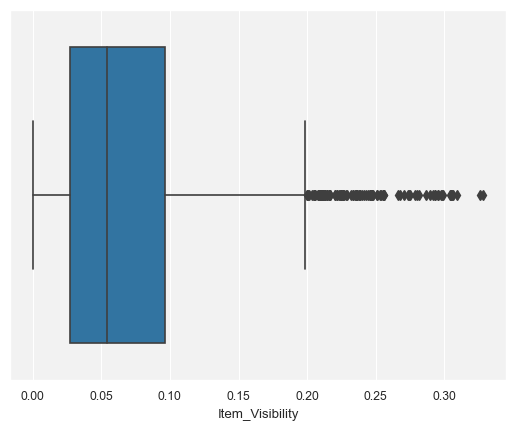

In [19]:
sns.boxplot(x=x_train['Item_Visibility'])

Esse atributo possui vários outliers. Mas como foi analisado no projeto de análise de dados, não necessariamente os outliers significam erros. Aqui são itens que possuem alta visibilidade nas prateleiras das lojas.

**Item_MRP**

<Axes: xlabel='Item_MRP'>

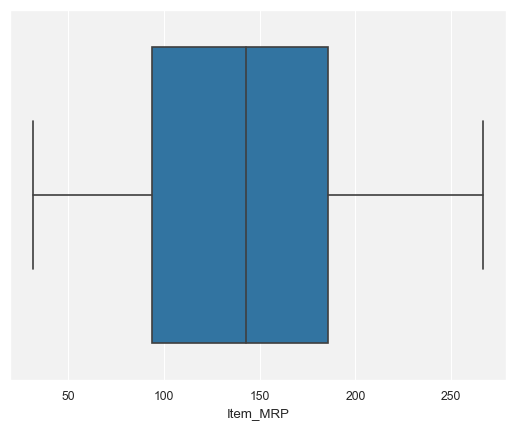

In [20]:
sns.boxplot(x=x_train['Item_MRP'])

**Item_Fat_Content**

In [21]:
x_train['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    3841
Regular    2141
LF          234
reg          91
low fat      85
Name: count, dtype: int64

Temos que lidar com esses itens aqui.

**Item_Type**

In [22]:
x_train['Item_Type'].value_counts()

Item_Type
Fruits and Vegetables    920
Snack Foods              902
Household                678
Frozen Foods             652
Dairy                    515
Canned                   470
Baking Goods             470
Health and Hygiene       411
Soft Drinks              332
Meat                     328
Breads                   182
Hard Drinks              158
Others                   124
Starchy Foods            117
Breakfast                 86
Seafood                   47
Name: count, dtype: int64

Pode-se dizer que está desbalanceado, mas a quantidade de registros pode ser suficiente para o modelo conseguir aprender.

**Outlet_Identifier**

In [23]:
x_train['Outlet_Identifier'].value_counts()

Outlet_Identifier
OUT018    714
OUT049    712
OUT017    711
OUT045    696
OUT027    694
OUT013    694
OUT035    688
OUT046    682
OUT010    404
OUT019    397
Name: count, dtype: int64

Está ok.

**Outlet_Establishment_Year**

In [24]:
x_train['Outlet_Establishment_Year'].value_counts()

Outlet_Establishment_Year
1985    1091
2009     714
1999     712
2007     711
2002     696
1987     694
2004     688
1997     682
1998     404
Name: count, dtype: int64

Está ok, embora eu acredite que essa variável seja irrelevante para o modelo.

**Outlet_Size**

In [25]:
x_train['Outlet_Size'].value_counts()

Outlet_Size
Medium    2120
Small     1767
High       694
Name: count, dtype: int64

Está ok.

**Outlet_Location_Type**

In [26]:
x_train['Outlet_Location_Type'].value_counts()

Outlet_Location_Type
Tier 3    2506
Tier 2    2095
Tier 1    1791
Name: count, dtype: int64

Está ok.

**Outlet_Type**

In [27]:
x_train['Outlet_Type'].value_counts()

Outlet_Type
Supermarket Type1    4183
Grocery Store         801
Supermarket Type2     714
Supermarket Type3     694
Name: count, dtype: int64

Está ok.

# 5) Tratamento de valores ausentes

In [28]:
display(x_train.shape)
x_train.isnull().sum()

(6392, 11)

Item_Identifier                 0
Item_Weight                  1091
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1811
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

**Item Weight**

In [29]:
x_train['Item_Weight'].fillna(x_train.groupby('Item_Type')['Item_Weight'].transform('mean'), inplace=True)
x_test['Item_Weight'].fillna(x_test.groupby('Item_Type')['Item_Weight'].transform('mean'), inplace=True)

Eu decidi utilizar o valor médio do Item weight agrupado por Item Type porque:
1. O atributo está bem distribuído, então não há diferença em usar a média ou a mediana (Talvez haja para departamentos).
2. O Item_Type é o atributo que possui maior correlação com o Item_Weight

**Outlet Size**

In [30]:
x_train['Outlet_Size'].fillna('-1', inplace=True)
x_test['Outlet_Size'].fillna('-1', inplace=True)

<Axes: >

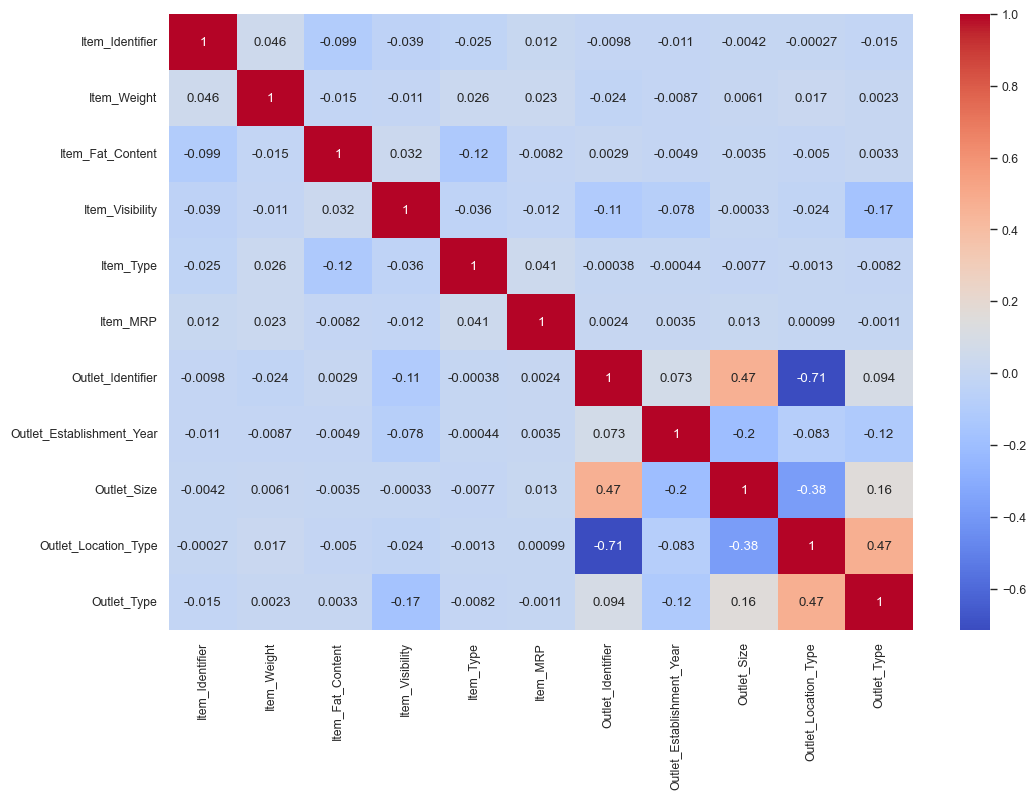

In [31]:
df_corr = x_train.copy()

le = LabelEncoder()
df_corr['Item_Identifier'] = le.fit_transform(df_corr['Item_Identifier'])
df_corr['Item_Fat_Content'] = le.fit_transform(df_corr['Item_Fat_Content'])
df_corr['Item_Type'] = le.fit_transform(df_corr['Item_Type'])
df_corr['Outlet_Identifier'] = le.fit_transform(df_corr['Outlet_Identifier'])
df_corr['Outlet_Size'] = le.fit_transform(df_corr['Outlet_Size'])
df_corr['Outlet_Location_Type'] = le.fit_transform(df_corr['Outlet_Location_Type'])
df_corr['Outlet_Type'] = le.fit_transform(df_corr['Outlet_Type'])

plt.figure(figsize=(12, 8))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')

In [32]:
x_train.groupby(['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'], as_index=False)['Item_Identifier'].count()

,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Identifier
0,-1,Tier 2,Supermarket Type1,1407
1,-1,Tier 3,Grocery Store,404
2,High,Tier 3,Supermarket Type1,694
3,Medium,Tier 1,Supermarket Type1,712
4,Medium,Tier 3,Supermarket Type2,714
5,Medium,Tier 3,Supermarket Type3,694
6,Small,Tier 1,Grocery Store,397
7,Small,Tier 1,Supermarket Type1,682
8,Small,Tier 2,Supermarket Type1,688


In [33]:
x_test.groupby(['Outlet_Size', 'Outlet_Location_Type'], as_index=False)['Item_Identifier'].count()

,Outlet_Size,Outlet_Location_Type,Item_Identifier
0,-1,Tier 2,448
1,-1,Tier 3,151
2,High,Tier 3,238
3,Medium,Tier 1,218
4,Medium,Tier 3,455
5,Small,Tier 1,379
6,Small,Tier 2,242


In [34]:
def fillna_outlet_size(row):
    if row.Outlet_Size == '-1':
        if row.Outlet_Location_Type == 'Tier 2':
            return 'Small'
        elif row.Outlet_Location_Type == 'Tier 3':
            return 'Medium' # Mas eu posso remover talvez.
    else: 
        return row.Outlet_Size 


In [35]:
x_train['Outlet_Size'] = x_train.apply(lambda row: fillna_outlet_size(row), axis=1)
x_test['Outlet_Size'] = x_test.apply(lambda row: fillna_outlet_size(row), axis=1)

Justificativa:
* Onde eu preenchi os valores ausentes como `Small`, foram em lojas cujo Location Type eram Tier 2, porque em todas as lojas Tier 2 eram Small;
* Onde eu preenchi os valores ausentes como `Medium`, foi igual ao valor majoritário do atributo Outlet Size cujo os Location Type eram iguais a `Tier 3`. Pode ser que essa relação não faça muito sentido e que eu tenha que mudar futuramente.

**Item_Fat_Content**

In [36]:
x_train['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    3841
Regular    2141
LF          234
reg          91
low fat      85
Name: count, dtype: int64

In [37]:
map_fat_content = {
    'Low Fat': 'Low Fat',
    'Regular': 'Regular',
    'LF': 'Low Fat',
    'reg': 'Regular',
    'low fat': 'Low Fat'
}

x_train['Item_Fat_Content'] = x_train['Item_Fat_Content'].map(map_fat_content)
x_test['Item_Fat_Content'] = x_test['Item_Fat_Content'].map(map_fat_content)

Justificativa: Como foi analisado no projeto de análise de dados, esses valores claramente se tratam de divergências no cadastro manual para o mesmo tipo de categoria. Portant, usando o pensamento lógico, percebemos que há apenas dois tipos de valores: `Low Fat` e `Regular`.

**Results**

In [38]:
display(x_train.isnull().sum())
display(x_test.isnull().sum())

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

# 6) Transformação dos atributos

* `Item_Identifier`: Ordinal Encoder ou Label Encoder
* `Item_Weight`: Padronização ou Normalização dos dados
* `Item_Fat_Content`: Label Encoder
* `Item_Visibility`: Padronização ou Normalização dos dados
* `Item_Type`: Ordinal Encoder ou One Hot Encoder
* `Item_MRP`: Padronização ou Normalização dos dados 
* `Outlet_Identifier`: Ordinal Encoder ou Label Encoder
* `Outlet_Establishment_Year`: Desconsiderar
* `Outlet_Size`: Ordinal Encoder (Testar One Hot Encoder)
* `Outlet_Location_Type`: Ordinal Encoder (Testar One Hot Encoder)
* `Outlet_Type`: Ordinal Encoder (Testar One Hot Encoder)

In [39]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder

In [123]:
x_train_transformed = x_train.copy()
x_test_transformed = x_test.copy()

In [124]:
map_fat_content_encode = {
    'Regular': 0,
    'Low Fat': 1
}

map_outlet_size_encode = {
    'Small': 0, 
    'Medium': 0.5, 
    'High': 1
}

map_location_type_encode = {
    'Tier 1': 0, 
    'Tier 2': 0.5, 
    'Tier 3': 1
}

map_outlet_type_encode = {
'Grocery Store': 0, 
'Supermarket Type1': 0.33, 
'Supermarket Type2': 0.66,
'Supermarket Type3': 1, 
}

In [125]:
x_train_transformed['Item_Fat_Content'] = x_train_transformed['Item_Fat_Content'].map(map_fat_content_encode)
x_train_transformed['Outlet_Size'] = x_train_transformed['Outlet_Size'].map(map_outlet_size_encode)
x_train_transformed['Outlet_Location_Type'] = x_train_transformed['Outlet_Location_Type'].map(map_location_type_encode)
x_train_transformed['Outlet_Type'] = x_train_transformed['Outlet_Type'].map(map_outlet_type_encode)

x_test_transformed['Item_Fat_Content'] = x_test_transformed['Item_Fat_Content'].map(map_fat_content_encode)
x_test_transformed['Outlet_Size'] = x_test_transformed['Outlet_Size'].map(map_outlet_size_encode)
x_test_transformed['Outlet_Location_Type'] = x_test_transformed['Outlet_Location_Type'].map(map_location_type_encode)
x_test_transformed['Outlet_Type'] = x_test_transformed['Outlet_Type'].map(map_outlet_type_encode)

In [126]:
display(x_test_transformed['Item_Fat_Content'].value_counts())
display(x_test_transformed['Outlet_Size'].value_counts())
display(x_test_transformed['Outlet_Location_Type'].value_counts())
display(x_test_transformed['Outlet_Type'].value_counts())

Item_Fat_Content
1    1357
0     774
Name: count, dtype: int64

Outlet_Size
0.0    1069
0.5     824
1.0     238
Name: count, dtype: int64

Outlet_Location_Type
1.0    844
0.5    690
0.0    597
Name: count, dtype: int64

Outlet_Type
0.33    1394
0.00     282
1.00     241
0.66     214
Name: count, dtype: int64

In [127]:
x_test_transformed

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
1748,FDS58,9.285000,0,0.021049,Snack Foods,161.0578,OUT045,2002,0.0,0.5,0.33
3681,FDI60,7.220000,0,0.038399,Baking Goods,61.9510,OUT045,2002,0.0,0.5,0.33
2557,FDG02,11.961084,1,0.011207,Canned,191.4188,OUT027,1985,0.5,1.0,1.00
2748,FDL10,8.395000,1,0.039485,Snack Foods,97.9042,OUT035,2004,0.0,0.5,0.33
425,FDY56,16.350000,0,0.062508,Fruits and Vegetables,227.1062,OUT049,1999,0.5,0.0,0.33
...,...,...,...,...,...,...,...,...,...,...,...
1386,FDQ56,13.288556,1,0.105086,Fruits and Vegetables,82.3908,OUT027,1985,0.5,1.0,1.00
3762,FDT04,17.250000,1,0.000000,Frozen Foods,37.5822,OUT010,1998,0.5,1.0,0.00
3302,DRH36,16.200000,1,0.033448,Soft Drinks,73.9696,OUT045,2002,0.0,0.5,0.33
8408,FDP48,7.520000,0,0.044272,Baking Goods,181.3950,OUT017,2007,0.0,0.5,0.33


In [128]:
ordinal_encoder = OrdinalEncoder()

features_encoded = ordinal_encoder.fit_transform(x_train_transformed[['Item_Identifier', 'Outlet_Identifier']])
features_encoded = pd.DataFrame(features_encoded, columns=['Item_Identifier_ordinal', 'Outlet_Identifier_ordinal'])

x_train_transformed['Item_Identifier_ordinal']= features_encoded['Item_Identifier_ordinal']
x_train_transformed['Outlet_Identifier_ordinal']= features_encoded['Outlet_Identifier_ordinal']

features_encoded = ordinal_encoder.transform(x_train_transformed[['Item_Identifier', 'Outlet_Identifier']])
features_encoded = pd.DataFrame(features_encoded, columns=['Item_Identifier_ordinal', 'Outlet_Identifier_ordinal'])

x_test_transformed['Item_Identifier_ordinal']= features_encoded['Item_Identifier_ordinal']
x_test_transformed['Outlet_Identifier_ordinal']= features_encoded['Outlet_Identifier_ordinal']

In [129]:
ohe = OneHotEncoder(sparse=False)

Item_Type_ohe_train = ohe.fit_transform(x_train_transformed[['Item_Type']])
Item_Type_ohe_test = ohe.transform(x_test_transformed[['Item_Type']])

# columns_ohe = ['Item_Type_{}'.format(str.replace(item ,' ', '_')) for item in list(ohe.categories_[0])]
columns_ohe_train = pd.DataFrame(Item_Type_ohe_train, columns=ohe.get_feature_names_out(['Item_Type']))
columns_ohe_test = pd.DataFrame(Item_Type_ohe_test, columns=ohe.get_feature_names_out(['Item_Type']))

for row in ohe.get_feature_names_out(['Item_Type']):
    x_train_transformed[row.replace(' ', '_')] = columns_ohe_train[row]
    x_test_transformed[row.replace(' ', '_')] = columns_ohe_test[row]

In [135]:
x_test_transformed

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Identifier_ordinal,Outlet_Identifier_ordinal,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods
1748,FDS58,9.285000,0,0.021049,Snack Foods,161.0578,OUT045,2002,0.0,0.5,0.33,1340.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3681,FDI60,7.220000,0,0.038399,Baking Goods,61.9510,OUT045,2002,0.0,0.5,0.33,451.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2557,FDG02,11.961084,1,0.011207,Canned,191.4188,OUT027,1985,0.5,1.0,1.00,455.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2748,FDL10,8.395000,1,0.039485,Snack Foods,97.9042,OUT035,2004,0.0,0.5,0.33,1461.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
425,FDY56,16.350000,0,0.062508,Fruits and Vegetables,227.1062,OUT049,1999,0.5,0.0,0.33,1300.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1386,FDQ56,13.288556,1,0.105086,Fruits and Vegetables,82.3908,OUT027,1985,0.5,1.0,1.00,89.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3762,FDT04,17.250000,1,0.000000,Frozen Foods,37.5822,OUT010,1998,0.5,1.0,0.00,528.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3302,DRH36,16.200000,1,0.033448,Soft Drinks,73.9696,OUT045,2002,0.0,0.5,0.33,361.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8408,FDP48,7.520000,0,0.044272,Baking Goods,181.3950,OUT017,2007,0.0,0.5,0.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
x_train_transformed

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Identifier_ordinal,Outlet_Identifier_ordinal,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods
4644,FDK02,12.500000,1,0.112682,Canned,119.1440,OUT018,2009,0.5,1.0,0.66,293.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3567,FDR56,15.500000,0,0.101336,Fruits and Vegetables,196.5768,OUT017,2007,0.0,0.5,0.33,891.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016,FDT40,5.985000,1,0.096337,Frozen Foods,125.2678,OUT017,2007,0.0,0.5,0.33,66.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2449,DRH03,17.250000,1,0.058690,Dairy,91.6120,OUT010,1998,0.5,1.0,0.00,753.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5162,FDD51,13.478811,1,0.119372,Dairy,45.2744,OUT027,1985,0.5,1.0,1.00,282.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442,FDR09,18.250000,1,0.078041,Snack Foods,258.4962,OUT018,2009,0.5,1.0,0.66,784.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3164,FDX35,11.580100,0,0.139913,Breads,227.9036,OUT019,1985,0.0,0.0,0.00,382.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7651,FDB05,5.155000,1,0.083328,Frozen Foods,247.2776,OUT049,1999,0.5,0.0,0.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5494,FDD33,13.201776,1,0.000000,Fruits and Vegetables,231.9642,OUT027,1985,0.5,1.0,1.00,1317.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# 7) Seleção de atributos

In [62]:
features_columns = [
    'Item_Identifier_ordinal', 
    'Outlet_Identifier_ordinal',
    # 'Item_Identifier', 
    'Item_Weight', 
    'Item_Fat_Content', 
    'Item_Visibility',
    'Item_Type', 
    'Item_MRP', 
    # 'Outlet_Identifier',
    # 'Outlet_Establishment_Year', 
    'Outlet_Size', 
    'Outlet_Location_Type',
    'Outlet_Type', 
]

In [66]:
x_train_transformed = x_train_transformed[features_columns]
x_test_transformed = x_test_transformed[features_columns]

In [68]:
display(x_train_transformed.head())
display(x_test_transformed.head())

,Item_Identifier_ordinal,Outlet_Identifier_ordinal,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type
4644,293.0,2.0,12.500000,1,0.112682,Canned,119.1440,0.5,1.0,0.66
3567,891.0,9.0,15.500000,0,0.101336,Fruits and Vegetables,196.5768,0.0,0.5,0.33
2016,66.0,8.0,5.985000,1,0.096337,Frozen Foods,125.2678,0.0,0.5,0.33
2449,753.0,9.0,17.250000,1,0.058690,Dairy,91.6120,0.5,1.0,0.00
5162,282.0,6.0,13.478811,1,0.119372,Dairy,45.2744,0.5,1.0,1.00


,Item_Identifier_ordinal,Outlet_Identifier_ordinal,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type
1748,1340.0,6.0,9.285000,0,0.021049,Snack Foods,161.0578,0.0,0.5,0.33
3681,451.0,2.0,7.220000,0,0.038399,Baking Goods,61.9510,0.0,0.5,0.33
2557,455.0,9.0,11.961084,1,0.011207,Canned,191.4188,0.5,1.0,1.00
2748,1461.0,8.0,8.395000,1,0.039485,Snack Foods,97.9042,0.0,0.5,0.33
425,1300.0,5.0,16.350000,0,0.062508,Fruits and Vegetables,227.1062,0.5,0.0,0.33


## 8) Padronização dos Dados

In [72]:
x_train_transformed

,Item_Identifier_ordinal,Outlet_Identifier_ordinal,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type
4644,293.0,2.0,12.500000,1,0.112682,Canned,119.1440,0.5,1.0,0.66
3567,891.0,9.0,15.500000,0,0.101336,Fruits and Vegetables,196.5768,0.0,0.5,0.33
2016,66.0,8.0,5.985000,1,0.096337,Frozen Foods,125.2678,0.0,0.5,0.33
2449,753.0,9.0,17.250000,1,0.058690,Dairy,91.6120,0.5,1.0,0.00
5162,282.0,6.0,13.478811,1,0.119372,Dairy,45.2744,0.5,1.0,1.00
...,...,...,...,...,...,...,...,...,...,...
2442,784.0,7.0,18.250000,1,0.078041,Snack Foods,258.4962,0.5,1.0,0.66
3164,382.0,6.0,11.580100,0,0.139913,Breads,227.9036,0.0,0.0,0.00
7651,NaN,NaN,5.155000,1,0.083328,Frozen Foods,247.2776,0.5,0.0,0.33
5494,1317.0,2.0,13.201776,1,0.000000,Fruits and Vegetables,231.9642,0.5,1.0,1.00


In [69]:
from sklearn.preprocessing import StandardScaler

In [71]:
standard_scaler = StandardScaler()

x_train_scaled = standard_scaler.fit_transform(x_train_transformed)
x_test_scaled = standard_scaler.transform()

ValueError: could not convert string to float: 'Canned'

## 11) Primeira modelagem

## 12) Testar diferentes modelos

## 13) Ajustar Hiperparâmetros